### Paxillin movie segmentation and object feature analysis

with Annabel's movies

Liya Ding, 2024.03

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler






# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
czimovie_dir =  '/mnt/d/lding/FA/data/20240226 FHL2 KI U2OS Actin 405, Pax 568, endo FHL2 488'

csv_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/csv'
plot_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/FA_plot'
seg_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/FA_seg'

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)
if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)
if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

In [3]:
# build the colormap with iterative tab20
tab20 = cm.get_cmap('tab20', 20)
for i in range(10):
    tab20.colors = np.concatenate([tab20.colors,tab20.colors],axis=0)    
tab20.colors = np.concatenate([np.zeros([1,4]),tab20.colors],axis=0)
print(tab20.colors)

[[0.         0.         0.         0.        ]
 [0.12156863 0.46666667 0.70588235 1.        ]
 [0.68235294 0.78039216 0.90980392 1.        ]
 ...
 [0.85882353 0.85882353 0.55294118 1.        ]
 [0.09019608 0.74509804 0.81176471 1.        ]
 [0.61960784 0.85490196 0.89803922 1.        ]]


### for each 3D stack run through MIP and 8th frame

In [4]:
# flag for some optinal parts
flag_plot = True
flag_plot_save = True
flag_seg_save = True
flag_csv_save = True
flag_run_all = False
flag_panel_plot = True

/home/lding/anaconda3/envs/aics_segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:108: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


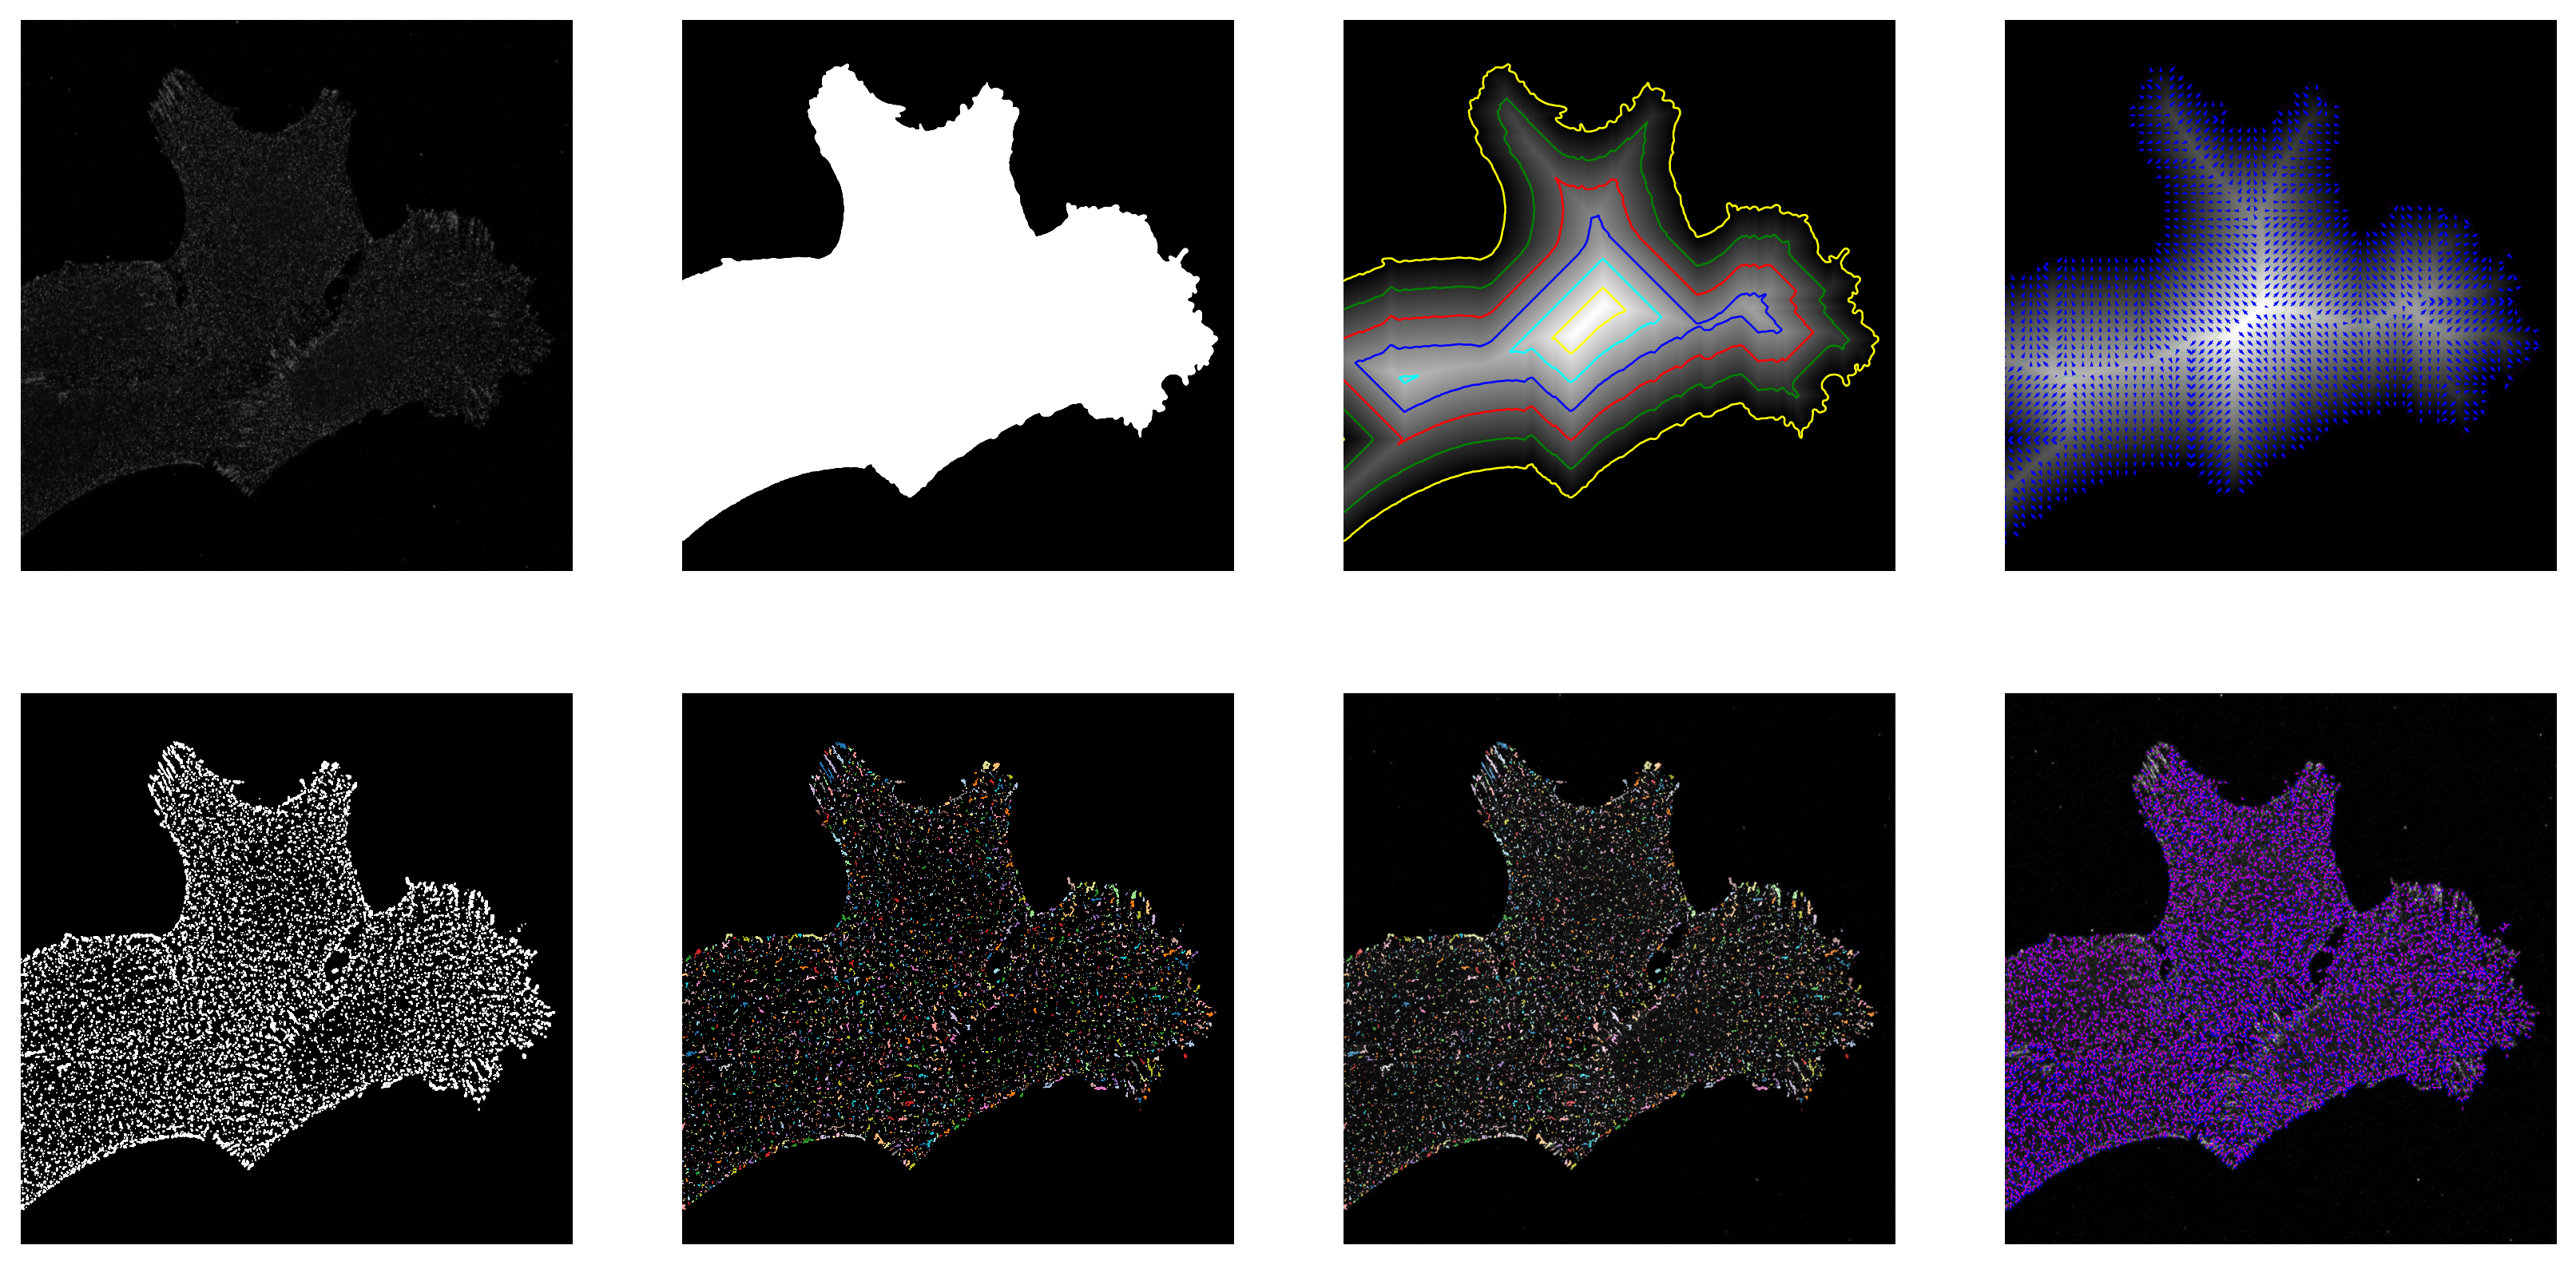

In [7]:
### for each movie, make sub-folders for different output for easier viewing in imagej
movie_mask_output_dir = os.path.join(seg_output_dir,  'mask')
movie_seg_output_dir = os.path.join(seg_output_dir,  'seg')
movie_label_output_dir = os.path.join(seg_output_dir,  'label')
movie_rgb_output_dir = os.path.join(seg_output_dir,  'rgb')    
movie_contour_output_dir = os.path.join(plot_output_dir,  'contour')
movie_quiver_cell_output_dir = os.path.join(plot_output_dir,  'quiver_cell')
movie_quiver_obj_output_dir = os.path.join(plot_output_dir,  'quiver_obj')
movie_label_color_output_dir = os.path.join(plot_output_dir,  'label_color')
movie_rgb_plot_output_dir = os.path.join(plot_output_dir,  'rgb_plot')
movie_panels_plot_output_dir = os.path.join(plot_output_dir,  'panel_plot')
movie_cluster_plot_output_dir = os.path.join(plot_output_dir,  'cluster_plot')

if not os.path.isdir(movie_mask_output_dir):          os.makedirs(movie_mask_output_dir)
if not os.path.isdir(movie_seg_output_dir):           os.makedirs(movie_seg_output_dir)
if not os.path.isdir(movie_label_output_dir):         os.makedirs(movie_label_output_dir)
if not os.path.isdir(movie_rgb_output_dir):           os.makedirs(movie_rgb_output_dir)
if not os.path.isdir(movie_contour_output_dir):       os.makedirs(movie_contour_output_dir)
if not os.path.isdir(movie_quiver_cell_output_dir):   os.makedirs(movie_quiver_cell_output_dir)
if not os.path.isdir(movie_quiver_obj_output_dir):    os.makedirs(movie_quiver_obj_output_dir)
if not os.path.isdir(movie_label_color_output_dir):   os.makedirs(movie_label_color_output_dir)
if not os.path.isdir(movie_rgb_plot_output_dir):      os.makedirs(movie_rgb_plot_output_dir)
if not os.path.isdir(movie_panels_plot_output_dir):   os.makedirs(movie_panels_plot_output_dir)
# if not os.path.isdir(movie_cluster_plot_output_dir):   os.makedirs(movie_panels_plot_output_dir)
    



filenames = [x for x in os.listdir(czimovie_dir) if os.path.isfile(os.path.join(czimovie_dir, x)) and ('.czi' in x)]

# if not in run all mode, only test with the first image of the first movie
if not flag_run_all:
    filenames = filenames[0:1]

for filenameID in range(len(filenames)):
    prop_df_pax = pd.DataFrame(columns=['filename','cell_ID','time_point','area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                    'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                    'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                    'cell_edge_dist','cell_edge_orient','diff_orient'])

    
    filename = filenames[filenameID]
    img = czifile.imread(os.path.join(czimovie_dir,filename))
    pax_img = img[0,0,0,:,:,:,0].squeeze()
    actin_img = img[0,0,-1,:,:,:,0].squeeze()
    
    intensity_scaling_param = [5,20]
    norm_pax_img = intensity_normalization(pax_img, scaling_param=intensity_scaling_param)
    norm_actin_img = intensity_normalization(actin_img, scaling_param=intensity_scaling_param)
  
       
    MIP_pax_img = norm_pax_img.max(axis=0)
    mid_ind = min(8, int(norm_pax_img.shape[0]*2/3))
    mid_pax_img = norm_pax_img[mid_ind,:,:]

    MIP_actin_img = norm_actin_img.max(axis=0)

    smooth_MIP_actin_img = gaussian_filter(MIP_actin_img,sigma=4,mode='nearest',truncate=3)
    ### low threshold to get cell masks
    new_cell_mask = smooth_MIP_actin_img>0.02
    ### remove isolated small objects (small regions due to noise)
    new_cell_mask = remove_small_objects(new_cell_mask>0, min_size=10000, connectivity=1, in_place=False)        
    # remove holes
    new_cell_mask = ndimage.binary_fill_holes(new_cell_mask)
    # calculate the distance map
    distance_taxicab = distance_transform_cdt(new_cell_mask, metric="taxicab")

    smooth_MIP_pax_img = gaussian_filter(MIP_pax_img,sigma=1,mode='nearest',truncate=3)
    input_pax_img = MIP_pax_img
    ## PARAMETERS for vesselness filter step ##
    
    thresh_sauvola = threshold_sauvola(smooth_MIP_pax_img, window_size=51)
    binary_sauvola = smooth_MIP_pax_img > thresh_sauvola*2

    f2_param = [[3, 0.75]]
    pax_res_3 = filament_2d_wrapper(smooth_MIP_pax_img, f2_param)

    f2_param = [[2, 0.85]]
    pax_res_2 = filament_2d_wrapper(smooth_MIP_pax_img, f2_param)


    f2_param = [[1, 2]]
    pax_res_1 = filament_2d_wrapper(smooth_MIP_pax_img, f2_param)

    pax_seg_1 = pax_res_1 > 1
    pax_seg_2 = pax_res_2 > 0.85
    pax_seg_3 = pax_res_3 > 0.75

    pax_seg = (pax_seg_1 + pax_seg_2 + pax_seg_3 + binary_sauvola)>0
    


    # remove segmentation outside of the cell
    pax_seg = pax_seg*new_cell_mask
    # remove single pixel objects
    pax_seg = remove_small_objects(pax_seg>0, min_size=2, connectivity=1, in_place=False)

    # label segmentations and calculate the region properties
    label_pax_seg = label(pax_seg)
    regionprops_pax = regionprops(label_pax_seg,intensity_image=input_pax_img)
        
    # prepare the color map with max of the labels for display (consistent through all images)
    max_label = label_pax_seg.max()
    newmap = cm.get_cmap('tab20', max_label+1)
    newmap.colors = tab20.colors[0:max_label+1,:]
    newmap.colors[0,:]  = np.zeros([1,4])
    newmap.colors[0,3] = 1
    pax_image_label_overlay = label2rgb(label_pax_seg, image=input_pax_img*2,kind='overlay',alpha=0.75,colors=newmap.colors)
  
    fig, ax = plt.subplots(1,2, figsize=(16,8), dpi=256, facecolor='w', edgecolor='k')
    ax[0,0].imshow(input_pax_img, cmap=plt.cm.gray,vmax=2,vmin=0)
    ax[0,0].axis('off')
    ax[0,1].imshow(label_pax_seg, cmap=newmap,interpolation='none')
    ax[0,1].axis('off')
            
                

In [ ]:
'd='+f'{cell_edge_dist:.0f}'+',oo='+f'{regionprops_pax[iL].orientation:.1f}'+',co='+f'{cell_edge_orient:.1f}'+',diff='+f'{diff_orient:.1f}'

In [ ]:
f'{cell_edge_dist:.0f}'

### belows are for debugging, keep it here until no longer needed

In [ ]:
pax_image_label_overlay = label2rgb(label_pax_seg, image=smooth_pax_img, bg_label=0,kind='overlay',alpha=0.5)
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(pax_image_label_overlay)

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
plt.imshow(pax_image_label_overlay, cmap=plt.cm.RdBu_r,vmax=0.1,vmin=0)
# plt.quiver(obj_Y,obj_X, cell_U,cell_V,color='blue')
Q = plt.quiver(obj_Y,obj_X, -obj_U,obj_V,color='m')#width=0.005,headwidth=0.1,headaxislength=0.02,headlength=0.01)
# plt.quiver(obj_Y,obj_X, cell_U,cell_V,color='blue')

plt.axis('off')

In [ ]:
plt.imshow(distance_taxicab)

grid_mask = np.zeros_like(new_cell_mask)
grid_mask[::30,::30] = new_cell_mask[::30,::30]
to_plot_X = X[grid_mask>0]
to_plot_Y = Y[grid_mask>0]
to_plot_U = n_v[grid_mask>0]
to_plot_H = n_h[grid_mask>0]

# plt.contour(X, Y, distance_taxicab,6,linewidths=2)    
plt.quiver(to_plot_X,to_plot_Y, -to_plot_U,to_plot_H,color='blue')
plt.axis('off')